In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import torch
import os 
from sklearn.model_selection import train_test_split

In [2]:
os.path.join('', '', '/test')

'/test'

In [3]:
def train_val_test_split(X, y, train_ratio, validation_ratio, test_ratio, random_state = 42, stratify = None):
    test_size = 1 - train_ratio # we first split into a train set and a val+test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state, stratify = stratify)
    test_size = test_ratio/(test_ratio + validation_ratio) # We then compute how the val+test set data should be split
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size, random_state = random_state, stratify = stratify) 
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
path = './data/'
os.listdir(path)

['sydney_captions',
 'scicap_data.zip',
 'kaggle_simpsons_characters',
 'polyvore',
 'scicap',
 'fashion200k',
 'UCM_captions.zip',
 'RSICD.zip',
 'polyvore-images.tar.gz',
 'RSICD',
 'UCM']

In [5]:
%%time
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

CPU times: user 2.86 s, sys: 472 ms, total: 3.34 s
Wall time: 2.45 s


In [6]:
def clip_predict_label(images, labels):
    inputs = processor(text=labels, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
    max_prob_ind = np.argmax(probs.detach().numpy(), axis = 1)
    return np.array(labels)[max_prob_ind]

In [7]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
images = [image] * 8

In [8]:
%%time
labels = ["a cat", "a dog", "a horse", "an elephant", "a rat", "a blanket", "a TV remote", "two cats", "two dogs", "two horses", "three cats", 
          "four dogs", "five horses", "a house", "two houses", "eight rats", "a tree", "six rats", "a river", "a school", "a woman", "a man", "a child", 
          "two children", "a president", "an animal", "a pet", "a video game", "a laptop", "a car", "a bike", "an umbrella", "a dress", "a skirt", 
          "a shoe", "a poster", "a movie", "a field", "a city", "a town", "a village", "an ocean", "a pool", "a flag", "a pig", "a cow", "a mouse",
         "a library", "a street", "a window", "a door", "a plant", "a flower", "a bag", "a scarf", "a hat"]
labels = ['an image of ' + l for l in labels]
print('Number of labels:', len(labels))
clip_predict_label(images, labels)

Number of labels: 56
CPU times: user 5.85 s, sys: 354 ms, total: 6.21 s
Wall time: 280 ms


array(['an image of two cats', 'an image of two cats',
       'an image of two cats', 'an image of two cats',
       'an image of two cats', 'an image of two cats',
       'an image of two cats', 'an image of two cats'], dtype='<U24')

# Fashion200k

In [9]:
%%time
path = './data/fashion200k/women/'

# First, get the main fashion categories (e.g. dresses, skirts, pants)
categories = os.listdir(path)
N = len(categories)
print('Number of main clothing categories:', N)
random_idx = np.random.randint(N) # Pick a random category
random_category = categories[random_idx]
category_path = os.path.join(path, random_category)

# List all subcategories (e.g. mini dresses, maxi dresses) for the randomly chosen category
subcategories = os.listdir(category_path)
M = len(subcategories)
print('Number of subcategories for {}: {}'.format(random_category, M))
random_idx = np.random.randint(N) # Pick a random subcategory
random_subcategory = subcategories[random_idx]
subcategory_path = os.path.join(category_path, random_subcategory)

# Get all the images belonging to the randomly chosen subcategory
images = os.listdir(subcategory_path)
random_idx = np.random.randint(len(images)) # Pick a random image
example_img = images[random_idx]
img_path = os.path.join(subcategory_path, example_img)
image = Image.open(img_path)

# Plot the random image example
plt.imshow(image)
plt.axis('off')
plt.title(img_path.replace(path, ''))
plt.show()

Number of main clothing categories: 5
Number of subcategories for jackets: 7


CPU times: user 160 ms, sys: 168 ms, total: 329 ms
Wall time: 149 ms


In [32]:
path = './data/fashion200k/labels/'
txt_files = os.listdir(path)
num_images = 0
for txt_file in txt_files:
    with open(os.path.join(path, txt_file), 'rb') as f:
        data = f.readlines()
    num_images += len(data)
print('Number of (labeled) images:', num_images)

Number of (labeled) images: 201838


In [11]:
image_paths = np.random.choice(img_paths, size = 100, replace = False)
images = [Image.open(i) for i in image_paths]

In [12]:
# The categories returned by our os.walk above contains both the main categories as well as their subcategories
subcategories = False
# Here, we make a choice to either only use the subcategories as labels, or only the main labels
labels = categories[5:] if subcategories else categories[:5]
# Remove underscores ('_')
labels = [l.replace('_', ' ') for l in labels]
# Remove trailing '(e)s' from the names (e.g. shirts -> shirt, dresses -> dress)
# Exeptions are to make sure we don't get blouses -> blous and not pants -> pant
labels = [l[:-2] if l.endswith('es') and l != 'blouses' else l[:-1] if 'pant' not in l else l for l in labels]
labels = ['an image of a ' + l for l in labels]
print(labels)

# Here we get the true labels of the images based on their paths
# The paths look like './data/fashion200k/women/main_category/subcategory', so we split on '/' to get the folder structure
# In this folder structure index 4 is for the main categories and 5 is for the subcategories
category_ind = 5 if subcategories else 4
true_labels = [p.split('/')[category_ind] for p in image_paths]

['an image of a dress', 'an image of a jacket', 'an image of a pants', 'an image of a skirt', 'an image of a top']


In [13]:
# Show the true labels
print(true_labels)

['dresses', 'jackets', 'tops', 'jackets', 'jackets', 'pants', 'skirts', 'jackets', 'tops', 'jackets', 'tops', 'jackets', 'skirts', 'tops', 'skirts', 'tops', 'tops', 'pants', 'dresses', 'tops', 'pants', 'pants', 'tops', 'jackets', 'tops', 'tops', 'pants', 'skirts', 'dresses', 'pants', 'pants', 'dresses', 'tops', 'tops', 'pants', 'skirts', 'dresses', 'tops', 'dresses', 'tops', 'jackets', 'tops', 'jackets', 'tops', 'dresses', 'pants', 'jackets', 'jackets', 'skirts', 'tops', 'dresses', 'tops', 'dresses', 'jackets', 'tops', 'dresses', 'jackets', 'dresses', 'skirts', 'dresses', 'pants', 'pants', 'jackets', 'skirts', 'tops', 'dresses', 'tops', 'skirts', 'pants', 'jackets', 'tops', 'jackets', 'dresses', 'pants', 'tops', 'dresses', 'tops', 'dresses', 'pants', 'jackets', 'tops', 'skirts', 'pants', 'dresses', 'tops', 'dresses', 'skirts', 'dresses', 'pants', 'skirts', 'skirts', 'pants', 'jackets', 'jackets', 'pants', 'jackets', 'dresses', 'dresses', 'skirts', 'pants']


CPU times: user 31.8 s, sys: 4.94 s, total: 36.7 s
Wall time: 2.31 s


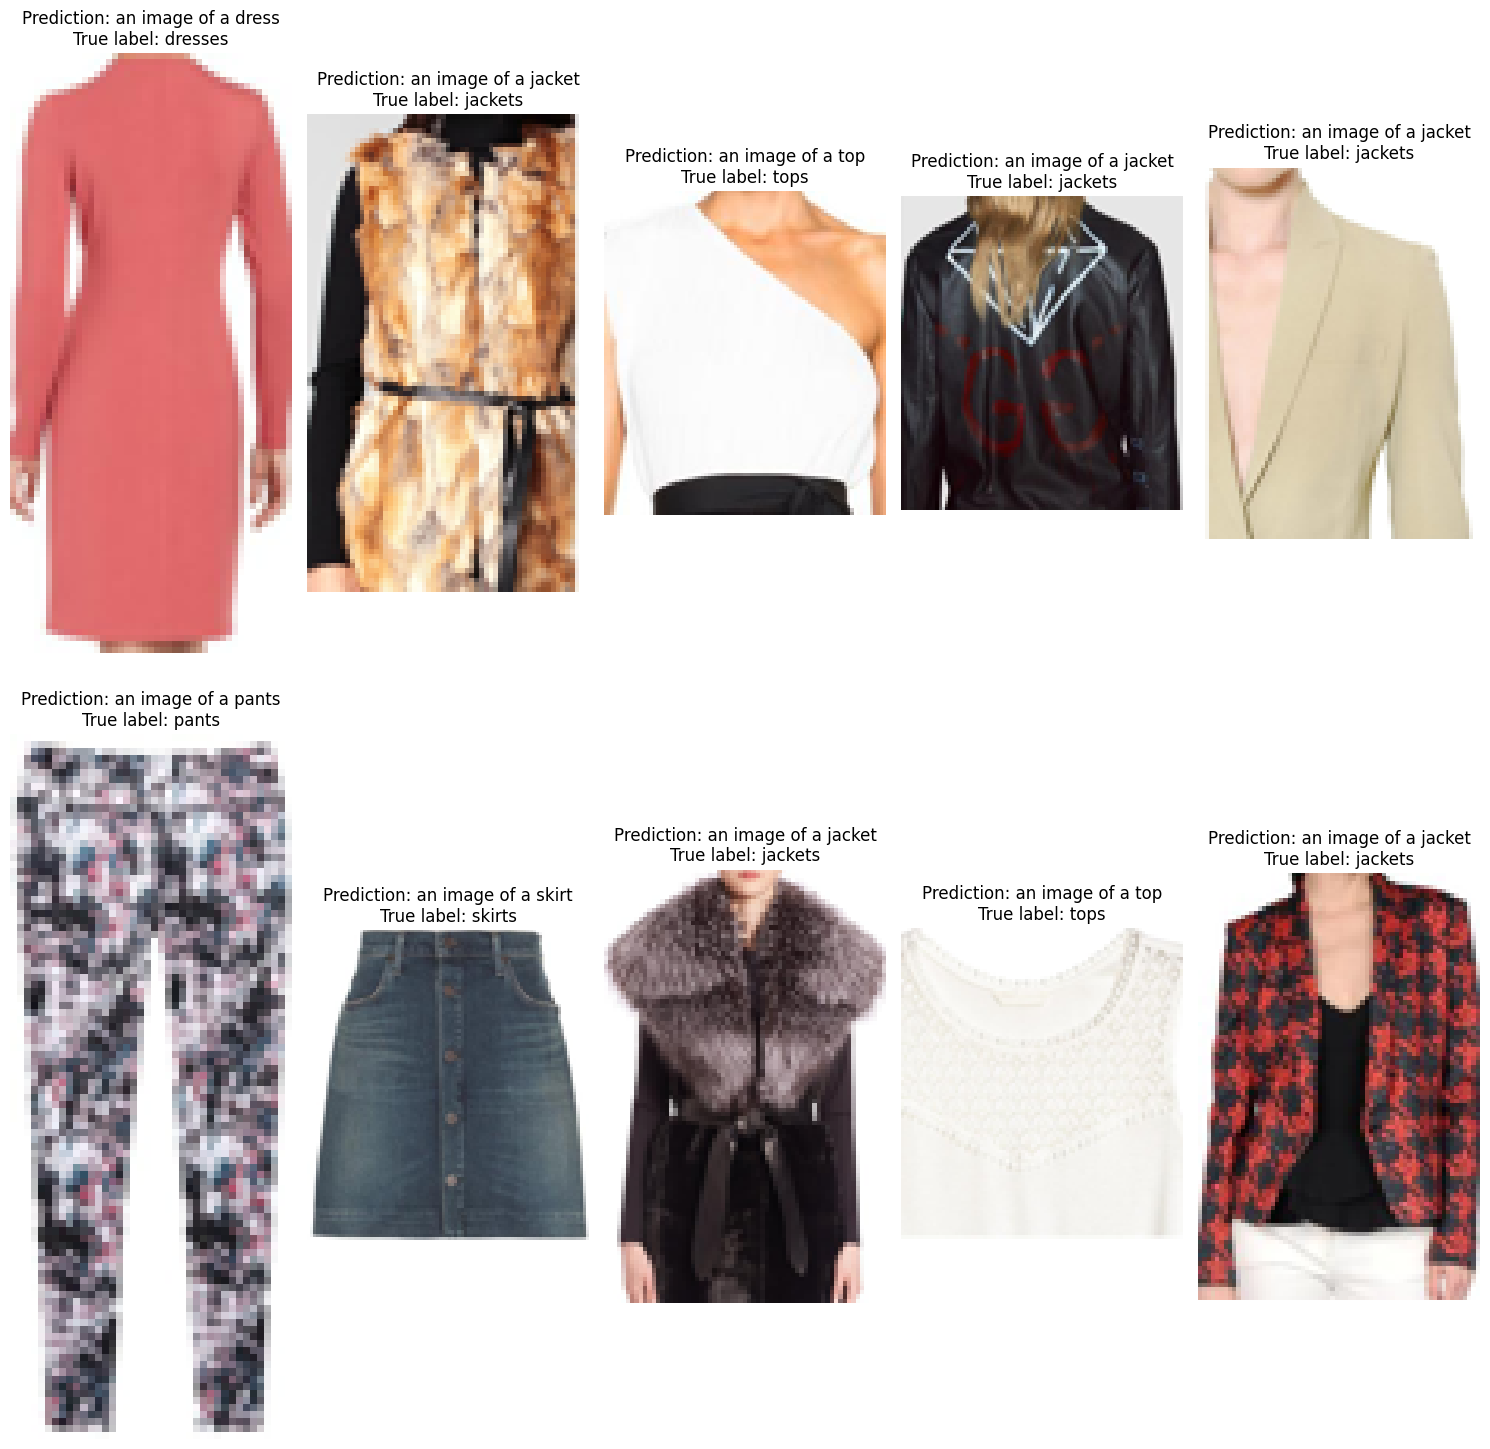

In [14]:
%%time
predicted_labels = clip_predict_label(images, labels)
num_pred = len(predicted_labels)
max_plots = 10
n_rows = 2
fig, ax = plt.subplots(nrows=n_rows, ncols=min(max_plots, num_pred)//n_rows, figsize=(15,15))
r, c = 0, 0
for i in range(min(max_plots,num_pred)):
    img, pred, label = images[i], predicted_labels[i], true_labels[i]
    (width, height) = (img.width * 100//img.height, 100)
    img = img.resize((width, height))
    ax[r, c].imshow(img)
    ax[r, c].set_title('Prediction: {}\nTrue label: {}'.format(pred, label))
    ax[r, c].axis('off')
    c += 1
    if c >= min(max_plots, num_pred)//n_rows:
        r += 1
        c = 0
plt.tight_layout()

# Polyvore

33375
./data/polyvore/images/195940748


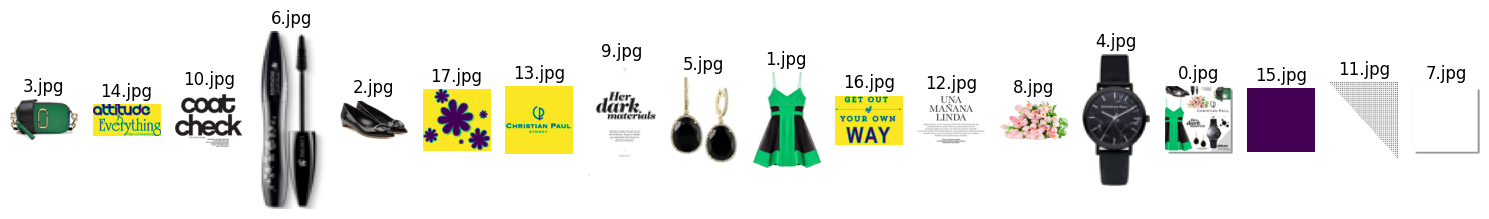

In [37]:
path = './data/polyvore/images'
image_folders = os.listdir(path)
print(len(image_folders))
chosen_folder = np.random.choice(image_folders)
folder_path = os.path.join(path, chosen_folder)
print(folder_path)
imgs = os.listdir(folder_path)
num_imgs = len(imgs)

fig, ax = plt.subplots(nrows=1, ncols=num_imgs, figsize=(15,15))

for i, img_path in enumerate(imgs):
    img = Image.open(os.path.join(folder_path,img_path))
    (width, height) = (img.width * 100//img.height, 100)
    img = img.resize((width, height))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(img_path, fontsize = 12)
plt.tight_layout()
plt.show()

In [38]:
path = './data/polyvore/{}_no_dup.json'
with open(path.format('test'), 'r') as f:
    data_test = json.load(f)
    test_ids = [d['set_id'] for d in data_test]
with open(path.format('valid'), 'r') as f:
    data_valid = json.load(f)
    valid_ids = [d['set_id'] for d in data_valid]
with open(path.format('train'), 'r') as f:
    data_train = json.load(f)
    train_ids = [d['set_id'] for d in data_train]
    
ids = []
if chosen_folder in train_ids:
    print(chosen_folder, "is in the train set.")
    data = data_train
elif chosen_folder in valid_ids:
    print(chosen_folder, "is in the validation set.")
    data = data_valid
elif chosen_folder in test_ids:
    print(chosen_folder, "is in the test set.")
    data = data_test
else:
    print(chosen_folder, "is not in the train, validation or test set.")
    data = None
if data:
    for d in data:
        if d['set_id'] == chosen_folder:
            # print(d)
            print(d['desc'])
            print(d['name'])
            for item in d['items']:
                print(item)
        ids.append(d['set_id'])

195940748 is in the train set.
A fashion look from April 2016 by sans-moderation featuring David Koma, Rupert Sanderson, Marc Jacobs, Effy Jewelry, LancÃ´me, contemporary and christianpaul
Preppy
{'index': 1, 'name': 'david dress', 'price': 430.0, 'likes': 971, 'image': 'http://img1.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=191606384', 'categoryid': 3}
{'index': 2, 'name': 'rupert sanderson patent leather ballerinas', 'price': 400.0, 'likes': 82, 'image': 'http://img2.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=164949794', 'categoryid': 47}
{'index': 3, 'name': 'marc jacobs colorblock leather shoulder bag', 'price': 310.0, 'likes': 51, 'image': 'http://img1.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=165902225', 'categoryid': 37}
{'index': 4, 'name': 'strand marble', 'price': 155.0, 'likes': 167, 'image': 'http://img1.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=169012740', 'categoryid': 61}
{'index': 5, 'name': 'effy black onyx ct. t.w. diamond ct. t.w. drop e

In [17]:
os.listdir('./data/polyvore/')

['train_no_dup.json',
 'fill_in_blank_test.json',
 'test_no_dup.json',
 'valid_no_dup.json',
 'fashion_compatibility_prediction.txt',
 'images']

# SciCap

Number of captions: 333442
Train images: 106834
Image caption: Fig. 3. This shows the improvement of Top-1 accuracy of the RNN in Section.IV as training progresses. The accuracy is reported as a ratio of the correctly predicted sequences to the total number of validation sequences.


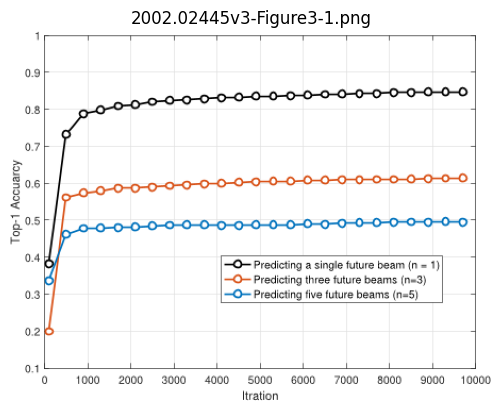

In [41]:
# Acquire all train images WITHOUT subfigures (like S-CLIP paper does)
img_path = './data/scicap/SciCap-No-Subfig-Img/train'
train_images = os.listdir(img_path)
random_idx = np.random.randint(len(train_images))
example_img = train_images[random_idx]
image = Image.open(os.path.join(img_path, example_img))

# Contains captions of all train instances (with and without subfigures)
caption_path = './data/scicap/SciCap-Caption-All/train'
train_captions = os.listdir(caption_path)
example_caption = example_img.replace('.png', '') + '.json'
with open(os.path.join(caption_path, example_caption), 'r') as f:
    data = json.load(f)
    
# Print + plot some statistics
print('Number of captions:', len(train_captions))
print('Train images:', len(train_images))
print('Image caption:', data['0-originally-extracted'])
plt.imshow(image)
plt.axis('off')
plt.title(example_img)
plt.show()

# To do: remove irrelevant captions from the set of captions (i.e. those for figures with subfigures)

# Sydney captions

In [19]:
with open('./data/sydney_captions/dataset.json', 'rb') as f:
    data = json.load(f)

print('Number of images:', len(data['images']))

# Print some examples of captions
for i in range(5):
    raw_sent = [s['raw']  for s in data['images'][i]['sentences']]
    print(raw_sent)

Number of images: 613
['A residential area with houses arranged neatly .', 'A residential area with houses arranged neatly and some roads go through this area .', 'A residential area with houses arranged neatly while some roads and railways go through .', 'A residential area with houses arranged neatly while many plants on the roadside .', 'A residential area with houses arranged neatly and some railways beside .']
['Lots of houses with red and orange roofs arranged in lines .', 'A residential area with houses arranged neatly and some roads go through this area .', 'A town with many houses arranged in lines while some cars on the roads .', 'A residential area with houses arranged neatly while many plants on the roadside .', 'A residential area with houses arranged neatly .']
['Lots of houses with red and orange roofs arranged in lines .', 'A residential area with houses arranged neatly and some roads go through this area .', 'A town with many houses arranged in lines while some cars on

In [20]:
from textwrap import wrap
def remote_sensing_stats(path, img_folder, json_file, num_examples = 5):
    img_path = os.path.join(path, img_folder)
    with open(os.path.join(path,json_file), 'rb') as f:
        data = json.load(f)
    
    print('Number of images:', len(data['images']))

    random_ind = np.random.choice(np.arange(len(data['images'])), size = num_examples, replace = False)
    # Print some examples of captions
    # equivalent but more general
    fig, ax = plt.subplots(nrows=1, ncols=num_examples, figsize=(15,15))
    for i, idx in enumerate(random_ind):
        img_data = data['images'][idx]
        img = Image.open(os.path.join(img_path, img_data['filename']))
        raw_sent = np.random.choice(img_data['sentences'])['raw']
        # print(raw_sent)
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title('ID: ' + str(idx) + '\n' + '\n'.join(wrap(raw_sent, 25)), fontsize = 15)
    plt.tight_layout()
        # plt.show()

# UCM

Number of images: 2100


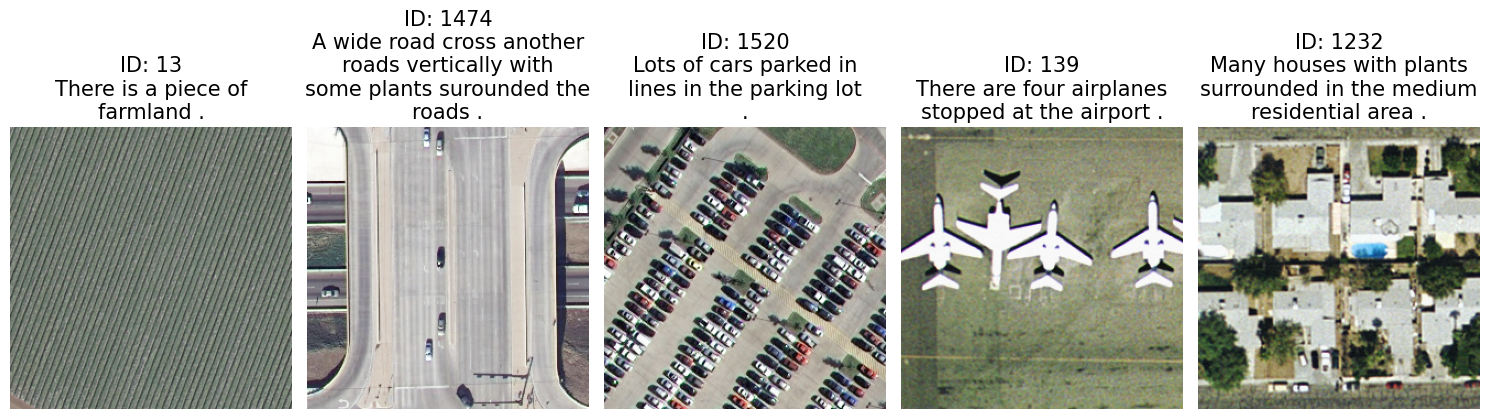

In [21]:
path = './data/UCM/'
img_folder = 'imgs'
json_file = 'dataset.json'
remote_sensing_stats(path, img_folder, json_file)

# RSICD

Number of images: 10921


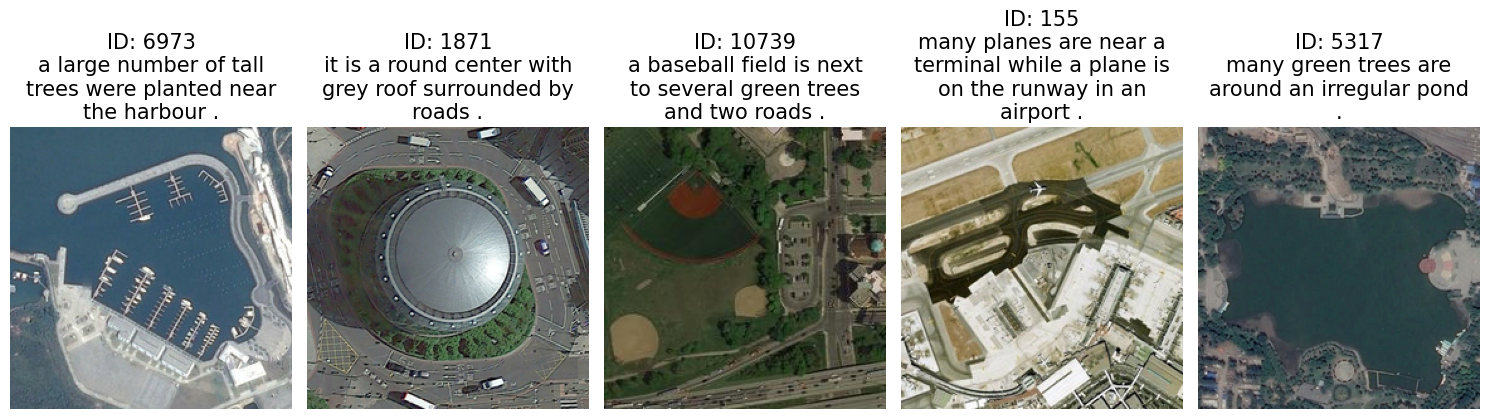

In [22]:
path =  './data/RSICD/'
img_folder = 'RSICD_images'
json_file = 'dataset_rsicd.json'
remote_sensing_stats(path, img_folder, json_file)

# Sydney

In [23]:
path = './data/sydney_captions/'
img_folder = 'images'
json_file = 'dataset.json'

remote_sensing_stats(path, img_folder, json_file)

Number of images: 613


# Simpsons

In [34]:
path = './data/kaggle_simpsons_characters/kaggle_simpson_testset/kaggle_simpson_testset'
os.listdir(path)

['abraham_grampa_simpson_0.jpg',
 'abraham_grampa_simpson_1.jpg',
 'abraham_grampa_simpson_10.jpg',
 'abraham_grampa_simpson_11.jpg',
 'abraham_grampa_simpson_12.jpg',
 'abraham_grampa_simpson_13.jpg',
 'abraham_grampa_simpson_14.jpg',
 'abraham_grampa_simpson_15.jpg',
 'abraham_grampa_simpson_16.jpg',
 'abraham_grampa_simpson_17.jpg',
 'abraham_grampa_simpson_18.jpg',
 'abraham_grampa_simpson_19.jpg',
 'abraham_grampa_simpson_2.jpg',
 'abraham_grampa_simpson_20.jpg',
 'abraham_grampa_simpson_21.jpg',
 'abraham_grampa_simpson_22.jpg',
 'abraham_grampa_simpson_23.jpg',
 'abraham_grampa_simpson_24.jpg',
 'abraham_grampa_simpson_25.jpg',
 'abraham_grampa_simpson_26.jpg',
 'abraham_grampa_simpson_27.jpg',
 'abraham_grampa_simpson_28.jpg',
 'abraham_grampa_simpson_29.jpg',
 'abraham_grampa_simpson_3.jpg',
 'abraham_grampa_simpson_30.jpg',
 'abraham_grampa_simpson_31.jpg',
 'abraham_grampa_simpson_32.jpg',
 'abraham_grampa_simpson_33.jpg',
 'abraham_grampa_simpson_34.jpg',
 'abraham_grampa_s